In [ ]:
import numpy as np
import pandas as pd
import requests
import os
import json
from glob import glob
from datetime import datetime, timedelta
from urllib.parse import quote
import matplotlib.pyplot as plt

In [ ]:
# Variables
api_key = 'YOUR KEY HERE'
city = 'Lo Barnechea'
start_date = datetime.strptime('2007-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-03-26', '%Y-%m-%d')
frequency = '1'  # Hourly

In [ ]:
# Function to generate monthly date ranges
def generate_month_ranges(start, end):
    current = start
    while current <= end:
        month_end = (current.replace(day=28) + timedelta(days=4)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        yield current, month_end
        current = month_end + timedelta(days=1)

In [ ]:
# Loop through each month and download data
for start, end in generate_month_ranges(start_date, end_date):
    encoded_city = quote(city)
    url = f'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={api_key}&q={encoded_city}&format=json&date={start.strftime("%Y-%m-%d")}&enddate={end.strftime("%Y-%m-%d")}&tp={frequency}'

    response = requests.get(url)
    monthly_data = response.json()

    # Save the JSON for the month
    with open(f'../data/weather_{city}_{start.strftime("%Y_%m")}.json', 'w') as f:
        json.dump(monthly_data, f)


In [ ]:
# Specify the directory where your JSON files are stored
directory = '../data/'
file_pattern = 'weather_*_*.json'  # Adjust the pattern to match your file names

# List of all JSON files to concatenate
json_files = glob(os.path.join(directory, file_pattern))

# Initialize a list to store all weather data
all_weather_data = []

# Loop through the files and read the data
for filename in json_files:
    with open(filename, 'r') as file:
        data = json.load(file)
        try:
            # Append the 'weather' part of each file's data to the all_weather_data list
            all_weather_data.extend(data['data']['weather'])
        except KeyError as e:
            print(f"KeyError for {filename}: {e}")

# Now `all_weather_data` contains the concatenated weather data from all files

# Save the combined data to a new JSON file
output_filename = '../data/combined_weather_data.json'
with open(output_filename, 'w') as outfile:
    # Create a new dictionary to store combined data with 'data' as the root key
    combined_data = {'data': {'weather': all_weather_data}}
    json.dump(combined_data, outfile, indent=4)

print(f'All weather data has been combined and saved to {output_filename}')

All weather data has been combined and saved to ../data/combined_weather_data.json


In [ ]:
# Load the combined JSON data
with open('../data/combined_weather_data.json', 'r') as file:
    combined_data = json.load(file)

# Extract the hourly data
hourly_data_list = []

for weather_day in combined_data['data']['weather']:
    date = weather_day['date']
    for hourly_data in weather_day['hourly']:
        # Flatten the hourly data and add the date to each entry
        hourly_data_flattened = {
            'date_time': f"{date} {int(hourly_data['time'])//100:02d}:00",  # Combines date and time
            'tempC': hourly_data['tempC'],
            'humidity': hourly_data['humidity'],
            'pressure': hourly_data['pressure'],
            'precipMM': hourly_data['precipMM'],
            'uvIndex': hourly_data['uvIndex'],
            'windspeedKmph': hourly_data['windspeedKmph'],
            'winddirDegree': hourly_data['winddirDegree'],
            'weatherDesc': hourly_data['weatherDesc'][0]['value'],  # Assumes first description is primary
        }
        hourly_data_list.append(hourly_data_flattened)

# Create a pandas DataFrame from the list of dictionaries
hourly_df = pd.DataFrame(hourly_data_list)

# Convert columns to numeric, if possible
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']
hourly_df[numeric_cols] = hourly_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert the 'date_time' column to datetime
hourly_df['date_time'] = pd.to_datetime(hourly_df['date_time'], format='%Y-%m-%d %H:%M')

# Set the 'date_time' as the index of the DataFrame
hourly_df.set_index('date_time', inplace=True)

# Save the DataFrame to a CSV file
csv_file_path = '../data/weather_data_lo_barnechea_hourly.csv'
hourly_df.to_csv(csv_file_path, index=True)

print(f'Hourly weather data saved to CSV file at: {csv_file_path}')

# Now hourly_df is a pandas DataFrame containing all the hourly data

Hourly weather data saved to CSV file at: ../data/weather_data_lo_barnechea_hourly.csv


- `pd.to_numeric()` is used to convert temperature and other specified columns to a numeric type. The `errors='coerce'` argument ensures that if any non-numeric values are encountered, they will be set to NaN (which stands for 'Not a Number') instead of raising an error.

In [ ]:
# Sort the DataFrame by date_time
hourly_df.sort_values(by='date_time', inplace=True)

In [ ]:
hourly_df

,tempC,humidity,pressure,precipMM,uvIndex,windspeedKmph,winddirDegree,weatherDesc
date_time,,,,,,,,
2010-01-01 00:00:00,11,73,1018,0.0,1,13,62,Clear
2010-01-01 01:00:00,11,73,1018,0.0,1,9,66,Clear
2010-01-01 02:00:00,11,73,1018,0.0,1,8,69,Clear
2010-01-01 03:00:00,12,73,1018,0.0,1,8,72,Clear
2010-01-01 04:00:00,13,68,1018,0.0,1,7,55,Clear
...,...,...,...,...,...,...,...,...
2024-03-25 19:00:00,21,37,1013,0.0,1,10,204,Clear
2024-03-25 20:00:00,19,42,1014,0.0,1,8,201,Clear
2024-03-25 21:00:00,18,44,1014,0.0,1,7,202,Clear


In [ ]:
hourly_df.isna().sum()

tempC            0
humidity         0
pressure         0
precipMM         0
uvIndex          0
windspeedKmph    0
winddirDegree    0
weatherDesc      0
dtype: int64

In [ ]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124752 entries, 2010-01-01 00:00:00 to 2024-03-25 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tempC          124752 non-null  int64  
 1   humidity       124752 non-null  int64  
 2   pressure       124752 non-null  int64  
 3   precipMM       124752 non-null  float64
 4   uvIndex        124752 non-null  int64  
 5   windspeedKmph  124752 non-null  int64  
 6   winddirDegree  124752 non-null  int64  
 7   weatherDesc    124752 non-null  object 
dtypes: float64(1), int64(6), object(1)
memory usage: 8.6+ MB


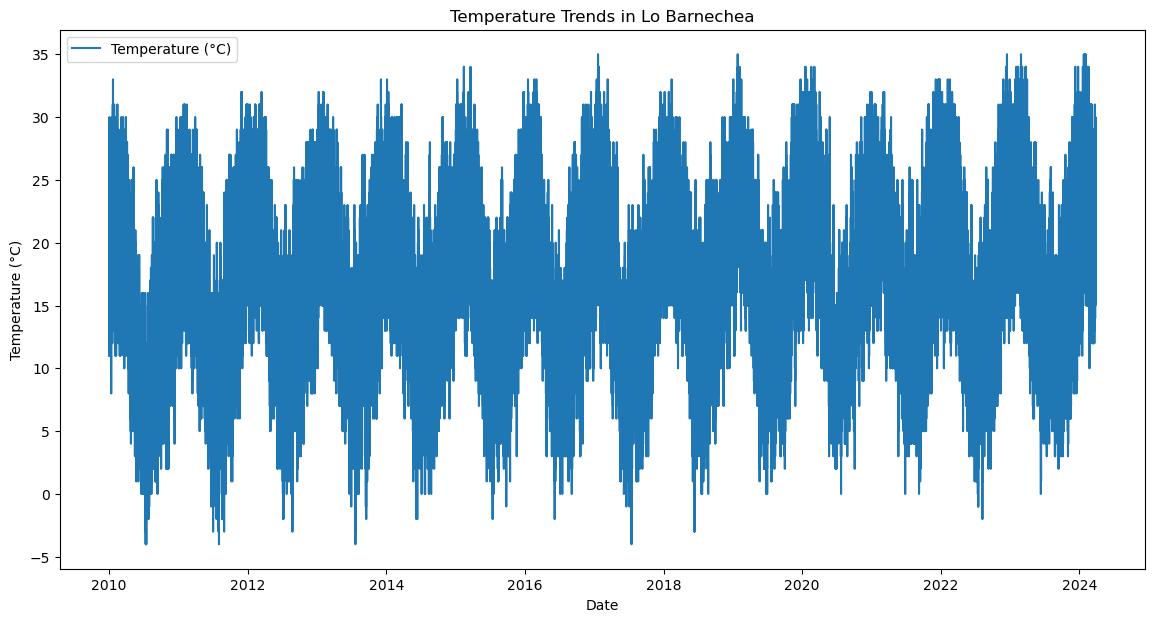

In [ ]:
# Temperature Trends Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['tempC'], label='Temperature (°C)')
plt.title('Temperature Trends in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

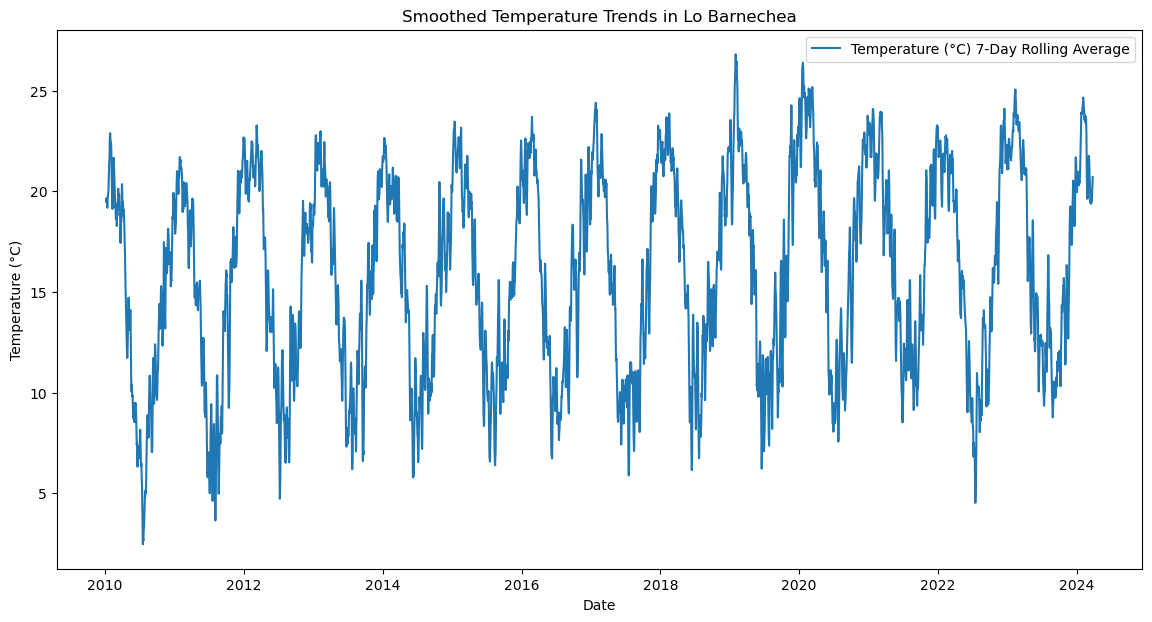

In [ ]:
# We should resample and calculate the mean for the numeric columns only
numeric_cols = ['tempC', 'humidity', 'pressure', 'precipMM', 'uvIndex', 'windspeedKmph', 'winddirDegree']

# Non-numeric columns will be excluded
df_daily = hourly_df[numeric_cols].resample('D').mean()

# Calculate a 7-day rolling average for temperature
df_daily['tempC_rolling'] = df_daily['tempC'].rolling(window=7).mean()

# Plot the rolling average temperature
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='Temperature (°C) 7-Day Rolling Average')
plt.title('Smoothed Temperature Trends in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In this code snippet:

- After converting the columns to numeric types, the data is resampled by day (`'D'`) to calculate the daily mean temperatures.
- A rolling average with a 7-day window is computed for the temperature, which smooths out the data for better trend visualization.
- The plot is then generated using the rolling average data, which should give a smoother curve and a more accurate representation of the temperature trends over time.

### Trend line on the daily mean temperature

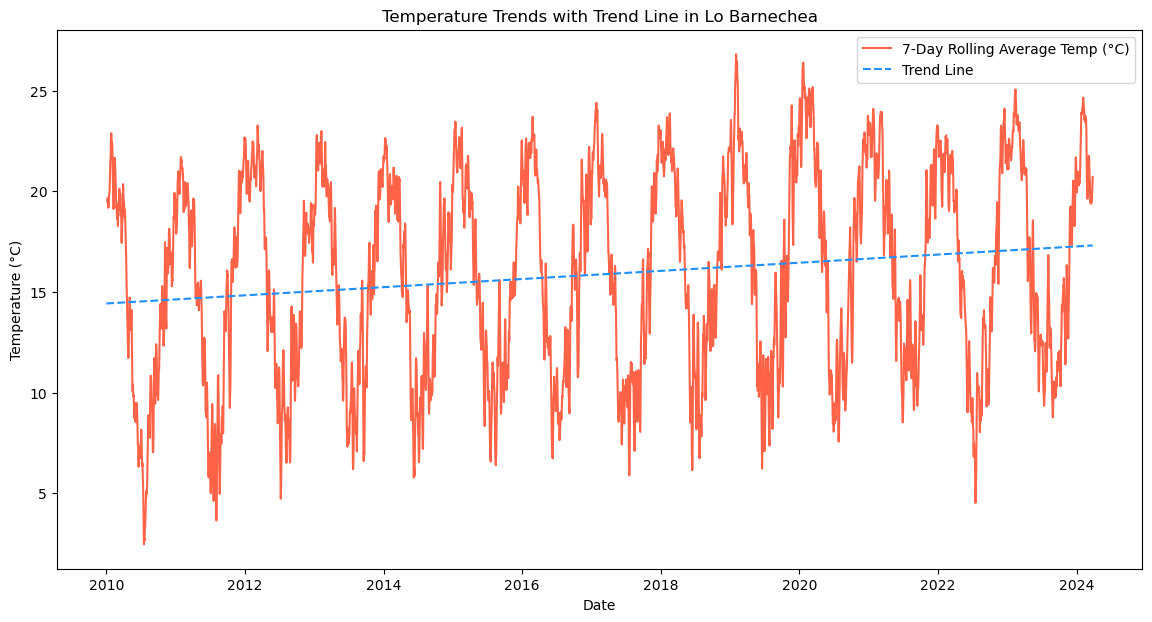

In [ ]:
# Fit a simple linear regression (trend line) on the daily mean temperature
# First, we need to create a series of ordinal date numbers for regression
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)

# Then, use numpy's polyfit to fit a first degree polynomial (linear)
# The polyfit function returns the coefficients for the equation of the line
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['tempC'], 1)

# Use the coefficients to create the equation of the line
polynomial = np.poly1d(coefficients)

# Now we can create y-values for our trend line based on the date ordinals
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

#Plotting the temperature and trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['tempC_rolling'], label='7-Day Rolling Average Temp (°C)', color='tomato')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='dodgerblue', linestyle='--')
plt.title('Temperature Trends with Trend Line in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In this code:

- `np.polyfit` is used to fit a linear trend line to the daily mean temperatures.
- `np.poly1d` creates a polynomial from the coefficients returned by `polyfit`.
- We add a new column to `df_daily` called 'trend_line', which stores the values of the trend line.
- The trend line is plotted along with the 7-day rolling average of temperature.


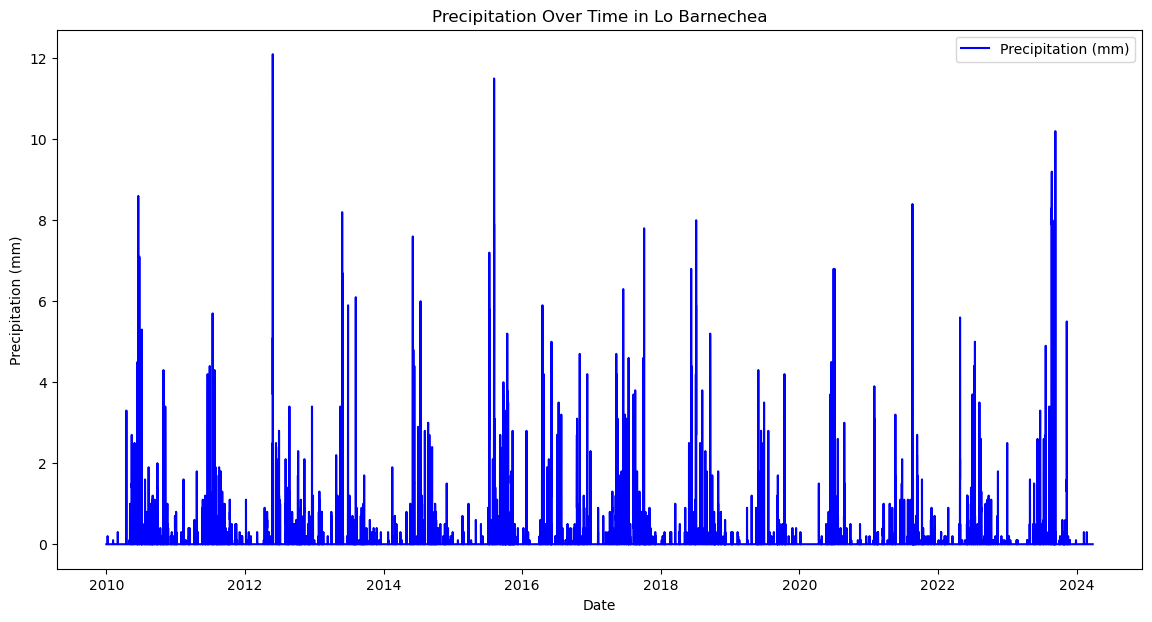

In [ ]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['precipMM'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

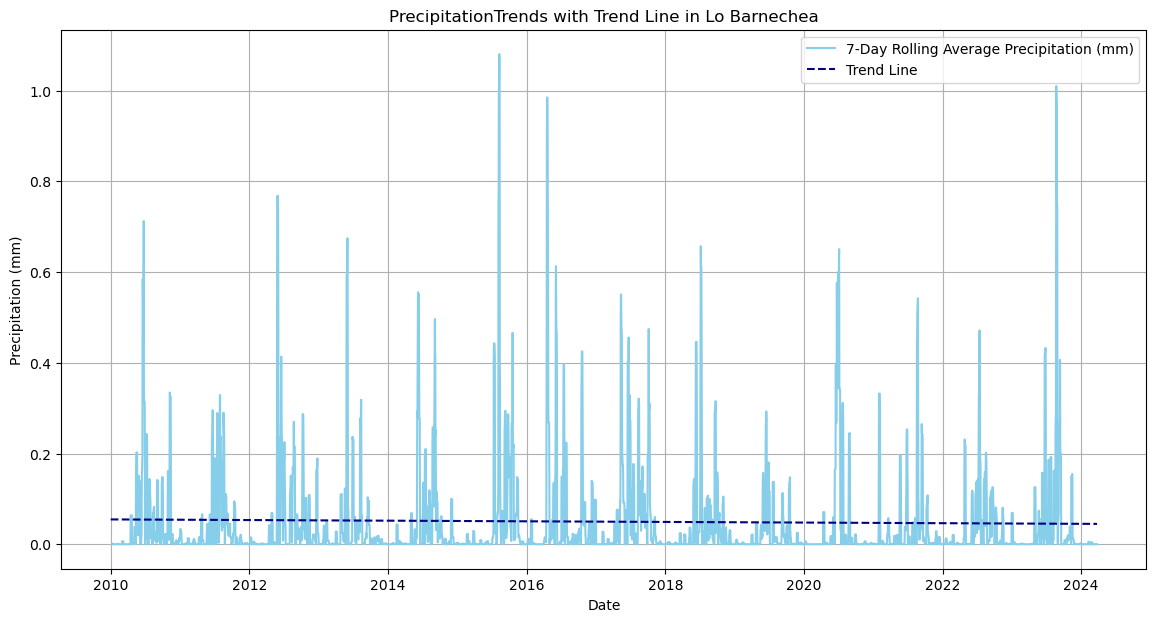

In [ ]:
# Calculate a 7-day rolling average for precipitation
df_daily['precipMM_rolling'] = df_daily['precipMM'].rolling(window=7).mean()

# Fit a simple linear regression (trend line) on the daily mean precipitation
df_daily['date_ordinal'] = df_daily.index.map(pd.Timestamp.toordinal)
coefficients = np.polyfit(df_daily['date_ordinal'], df_daily['precipMM'], 1)
polynomial = np.poly1d(coefficients)
df_daily['trend_line'] = polynomial(df_daily['date_ordinal'])

# Plotting the rolling average of precipitation with a trend line
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['precipMM_rolling'], label='7-Day Rolling Average Precipitation (mm)', color='skyblue')
plt.plot(df_daily.index, df_daily['trend_line'], label='Trend Line', color='navy', linestyle='--')
plt.title('PrecipitationTrends with Trend Line in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

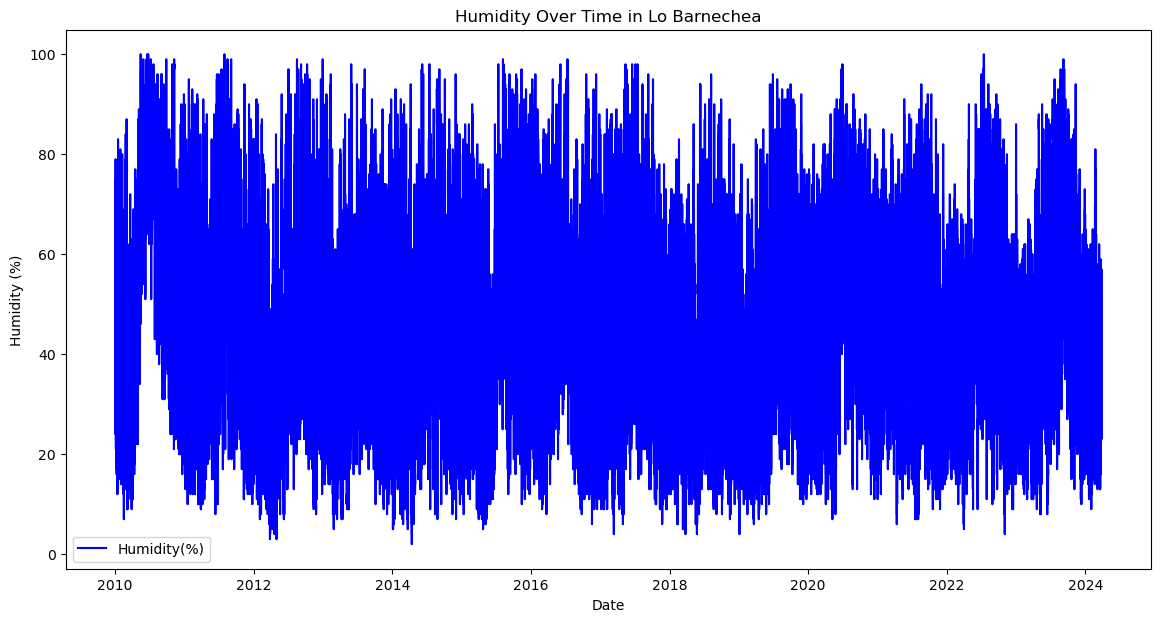

In [ ]:
# Precipitation Over Time
plt.figure(figsize=(14, 7))
plt.plot(hourly_df['humidity'], label='Humidity(%)', color='blue')
plt.title('Humidity Over Time in Lo Barnechea')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.show()